In [3]:
import json, os, itertools
from collections import defaultdict
import gurobipy as gp
import pandas as pd
import numpy as np
import re

BASE_DIR = r"D:\MINJI\NETWORK RELIABILITY\QGIS\7.Korea_Full\json"   
edge_fp   = r"D:\MINJI\NETWORK RELIABILITY\QGIS\7.Korea_Full\json\5 min\edges.json"
route_fp  = os.path.join(BASE_DIR, "routes_nodes.json")
demand_fp = os.path.join(BASE_DIR, "demand.json")
dept_fp   = os.path.join(BASE_DIR, "dep_time.json")

In [4]:
T = 96
max_wait = 3
CAPACITY = 3
failed_edges = {"e81"} # set(), {"e81"}
w1, w2, w3, w4 = 1000, 1000, 100, 500
BIG_M = 10**6
M = T
SINK  = "SINK"
HEADWAY_MIN = 1      
DWELL_MIN = 1     
FAIL_T = 48  


with open(edge_fp, encoding="utf-8") as f:
    edges_raw = json.load(f)
edges = {eid: (src, dst, int(tau)) for eid, (src, dst, tau) in edges_raw.items()}

with open(route_fp, encoding="utf-8") as f:
    routes_nodes = json.load(f)

with open(dept_fp, encoding="utf-8") as f:
    dep_time = {tr: int(t) for tr, t in json.load(f).items()}

with open(demand_fp, encoding="utf-8") as f:
    dem_raw = json.load(f)
demand = {tr: [(o, d, float(q)) for o, d, q in lst] for tr, lst in dem_raw.items()}

trains = list(routes_nodes)
nodes  = {n for _, (s, d, _) in edges.items() for n in (s, d)}
nodes.add(SINK)


# time expansion arcs
arc_list = []              
for eid, (src, dst, tau) in edges.items():
    for t in range(T + 1 - tau):
        if (eid in failed_edges) and (t + tau > FAIL_T):
            continue
        arc_list.append((f"{src}^{t}", f"{dst}^{t+tau}", eid, tau, t, t+tau))

for n in nodes - {SINK}:
    for w in range(1, max_wait+1):
        for t in range(T + 1 - w):
            arc_list.append((f"{n}^{t}", f"{n}^{t+w}", f"w_{n}_{w}", w, t, t+w))

for n in nodes - {SINK}:
    for t in range(T+1):
        arc_list.append((f"{n}^{t}", f"{SINK}^{t}", f"dummy_{n}", 0, t, t))

arc_idx = {info: i for i, info in enumerate(arc_list)}


# 캐싱: arc → 노드·시각 별 in/out
out_arcs = defaultdict(list)  
in_arcs  = defaultdict(list)   
node_in_arcs  = defaultdict(list) 
node_out_arcs = defaultdict(list)

for k, (fr, to, eid, _, t0, t1) in enumerate(arc_list):
    n_fr, tt_fr = fr.split("^"); tt_fr = int(tt_fr)
    n_to, tt_to = to.split("^"); tt_to = int(tt_to)

    out_arcs[(n_fr, tt_fr)].append(k)
    in_arcs [(n_to, tt_to)].append(k)

    if not eid.startswith(("w_", "dummy")):     
        node_out_arcs[n_fr].append(k)
        node_in_arcs [n_to].append(k)


# scheduled arrival time
sched = {}
for tr, path in routes_nodes.items():
    t = dep_time[tr]
    arr = {path[0]: {"arr": t, "dep": t}} 
    for i, (u, v) in enumerate(zip(path[:-1], path[1:])):
        eid = next(e for e, (s, d, _) in edges.items() if s == u and d == v)
        travel = edges[eid][2]
        t += travel
        arr[v] = {"arr": t, "dep": t}
        if i < len(path) - 2:  
            arr[v]["dep"] += DWELL_MIN
            t += DWELL_MIN
    sched[tr] = arr




def train_state_at_T0(tr, T0=FAIL_T):
    path = routes_nodes[tr]
    dep0 = dep_time[tr]
    if T0 <= dep0:
        return ('not_departed', path[0], dep0)

    for i in range(1, len(path)):
        u, v = path[i-1], path[i]
        t_dep_u = sched[tr][u]['dep']
        t_arr_v = sched[tr][v]['arr']
        if T0 <= t_arr_v:  
            if T0 > t_dep_u:
                eid = next(e for e, (s, d, _) in edges.items() if s == u and d == v)
                return ('enroute', v, t_arr_v, eid, t_dep_u)
            else:
                return ('not_departed', u, t_dep_u)

    terminal = path[-1]
    return ('finished', terminal, sched[tr][terminal]['arr'])

occ0 = defaultdict(int)  
states = {}
for tr in trains:
    st = train_state_at_T0(tr, FAIL_T)
    states[tr] = st
    if st[0] == 'enroute':
        _, v, t_arr_v, eid, t_dep_u = st
        for tt in range(max(FAIL_T, t_dep_u), t_arr_v):
            occ0[(eid, tt)] += 1
print("Initial occupancy on edges at T0:", dict(occ0))
print("Train states at T0:", states)




q_r = {tr: sum(q for *_, q in demand[tr]) for tr in trains}
print("Total demand:", sum(q_r.values()))

Initial occupancy on edges at T0: {('e93', 48): 2, ('e93', 49): 1, ('e93', 50): 1, ('e93', 51): 1, ('e89', 48): 1, ('e81', 48): 1, ('e81', 49): 1, ('e81', 50): 1, ('e61', 48): 2, ('e61', 49): 1, ('e61', 50): 1, ('e61', 51): 1, ('e43r', 48): 2, ('e43r', 49): 1, ('e43r', 50): 1, ('e43r', 51): 1, ('e17r', 48): 1, ('e17r', 49): 1, ('e9', 48): 2, ('e9', 49): 1, ('e9', 50): 1, ('e17', 48): 1, ('e17', 49): 1, ('e26r', 48): 1, ('e43', 48): 1, ('e43', 49): 1, ('e43', 50): 1, ('e61r', 48): 1, ('e61r', 49): 1, ('e66', 48): 1, ('e42r', 48): 1, ('e42r', 49): 1, ('e42r', 50): 1, ('e42r', 51): 1, ('e42r', 52): 1, ('e25', 48): 1, ('e25', 49): 1, ('e25', 50): 1, ('e16', 48): 1, ('e16', 49): 1, ('e42', 48): 1, ('e42', 49): 1, ('e42', 50): 1, ('e42', 51): 1, ('e42', 52): 1, ('e87r', 48): 1, ('e65r', 48): 1, ('e84', 48): 1, ('e73', 48): 1, ('e73', 49): 1, ('e60', 48): 1, ('e60', 49): 1, ('e40r', 48): 1, ('e32r', 48): 1, ('e19', 48): 1, ('e19', 49): 1, ('e60r', 48): 1, ('e60r', 49): 1, ('e73r', 48): 1, ('e

In [5]:
import re
from collections import defaultdict

# 노선별로 열차 묶기
def route_prefix(tr_id: str) -> str:
    m = re.match(r'^([^\d]+)\d+_\d+$', tr_id)
    return m.group(1) if m else tr_id.rsplit('_', 1)[0]

by_route = defaultdict(list)
for tr in trains:
    by_route[route_prefix(tr)].append(tr)
print("Trains by route:", dict(by_route))


# T_r = dep_time[r] + route_runtime[prefix(r)] + 4
def travel_time_only(path, edges):
    total = 0
    for u, v in zip(path[:-1], path[1:]):
        eid = next(e for e, (s, d, _) in edges.items() if s == u and d == v)
        total += edges[eid][2]
    return total

route_runtime = {}
for rname, tr_list in by_route.items():
    reps = [tr for tr in tr_list if re.fullmatch(re.escape(rname) + r'\d+_1', tr)]
    if not reps:
        reps = [tr for tr in tr_list if tr.endswith('_1')]
    if not reps:
        reps = [sorted(tr_list)[0]]

    rep = reps[0]
    base_run = travel_time_only(routes_nodes[rep], edges) 
    route_runtime[rname] = base_run

print("Route runtimes:", route_runtime)

PADDING_BASE = 4
T_limit = {}
for tr in trains:
    L = len(routes_nodes[tr]) - 1    
    dwell_need = max(0, L-1) * DWELL_MIN    
    base_run = route_runtime[route_prefix(tr)]
    T_limit[tr] = min(T, dep_time[tr] + base_run + dwell_need + PADDING_BASE)
print("Train limits:", T_limit)

Trains by route: {'경부고속철도': ['경부고속철도1_1', '경부고속철도1_2', '경부고속철도1_3', '경부고속철도1_4', '경부고속철도1_5', '경부고속철도1_6', '경부고속철도1_7', '경부고속철도1_8', '경부고속철도1_9', '경부고속철도1_10', '경부고속철도1_11', '경부고속철도1_12', '경부고속철도2_1', '경부고속철도2_2', '경부고속철도2_3', '경부고속철도2_4', '경부고속철도2_5', '경부고속철도2_6', '경부고속철도2_7', '경부고속철도2_8', '경부고속철도2_9', '경부고속철도2_10', '경부고속철도2_11'], '경부선': ['경부선1_1', '경부선1_2', '경부선1_3', '경부선1_4', '경부선1_5', '경부선1_6', '경부선2_1', '경부선2_2', '경부선2_3', '경부선2_4', '경부선2_5', '경부선2_6'], '경북선': ['경북선1_1', '경북선2_1'], '경전선': ['경전선1_1', '경전선1_2', '경전선2_1', '경전선2_2'], '동해선': ['동해선1_1', '동해선1_2', '동해선2_1', '동해선2_2'], '영동선': ['영동선1_1', '영동선2_1'], '장항선': ['장항선1_1', '장항선1_2', '장항선1_3', '장항선2_1', '장항선2_2', '장항선2_3'], '전라선': ['전라선1_1', '전라선1_2', '전라선1_3', '전라선2_1', '전라선2_2', '전라선2_3'], '중앙선': ['중앙선1_1', '중앙선1_2', '중앙선1_3', '중앙선1_4', '중앙선1_5', '중앙선1_6', '중앙선2_1', '중앙선2_2', '중앙선2_3', '중앙선2_4', '중앙선2_5', '중앙선2_6'], '충북선': ['충북선1_1', '충북선1_2', '충북선1_3', '충북선2_1', '충북선2_2', '충북선2_3'], '호남고속철도': ['호남고속철도1_1', '호남고속철도1_2', '호남고속철도1

In [6]:
# 계획 엣지 / blocked / 접미 실패 / 종료 허용노드
uv2eid = {}
dup_keys = set()
for eid, (s, d, _) in edges.items():
    key = (s, d)
    if key in uv2eid and uv2eid[key] != eid:
        dup_keys.add(key)
    else:
        uv2eid[key] = eid

if dup_keys:
    print(f"[warn] multiple eids share the same (u,v): {sorted(list(dup_keys))[:5]} ...")

def planned_eids_of(tr):
    """열차 tr의 계획 경로 상 (u,v)들에 대한 eid 리스트를 O(1)로 반환"""
    path = routes_nodes[tr]
    eids = []
    for u, v in zip(path[:-1], path[1:]):
        eid = uv2eid.get((u, v))
        if eid is None:
            raise KeyError(f"No edge (u={u} -> v={v}) found in edges; check routes_nodes or edges.json")
        eids.append(eid)
    return eids

planned_eids = {tr: planned_eids_of(tr) for tr in trains}
blocked = {tr: int(any(e in failed_edges for e in planned_eids[tr])) for tr in trains}


# 접미 실패 플래그 F_{r,i}와 reach_r, 그리고 노드별 종료 허용 allow_stop[(tr,n)]
def get_arrival(tr, node, default=10**9):
    return sched.get(tr, {}).get(node, {}).get("arr", default)
def get_departure(tr, node, default=10**9):
    return sched.get(tr, {}).get(node, {}).get("dep", default)

allow_stop = {}
reach = {}

for tr in trains:
    path = routes_nodes[tr]  
    eids = planned_eids[tr]   
    L = len(path) - 1

    last_node = path[-1]
    t_arrival_last = get_arrival(tr, last_node, default=10**9)
    reach[tr] = int(t_arrival_last <= T_limit[tr])  

    suffix_failed = [0] * (L + 1)
    hit = 0
    for i in range(L - 1, -1, -1):
        if eids[i] in failed_edges:
            hit = 1
        suffix_failed[i] = hit

    for i in range(1, L + 1):
        n = path[i]
        if i == L:
            allow = 1                      
        elif reach[tr] == 0:
            allow = 1                        
        else:
            allow = suffix_failed[i]          
        allow_stop[(tr, n)] = int(allow)

eid_to_arcidx = defaultdict(list)
dummy_idx_of = defaultdict(list)
wait_idx_of  = defaultdict(list)

for k, (_, _, eid, *_) in enumerate(arc_list):
    s_eid = str(eid)
    if s_eid.startswith("dummy_"):
        n = s_eid.split("dummy_", 1)[1]
        dummy_idx_of[n].append(k)
    elif s_eid.startswith("w_"):
        parts = s_eid.split("_", 2)
        if len(parts) >= 3:
            n = parts[1]
            wait_idx_of[n].append(k)    
    else:
        eid_to_arcidx[eid].append(k)
     
T_aff = [tr for tr in trains if blocked[tr] == 1]  
T_ok  = [tr for tr in trains if blocked[tr] == 0]   

In [ ]:
def build_base_model():

    m = gp.Model(); m.Params.OutputFlag = 1
    nA, nT = len(arc_list), len(trains)

    # 공통 변수 (모든 열차)
    x = m.addVars(nA, nT, vtype=gp.GRB.BINARY, name="x")
    for k, (fr, to, eid, _, t0, t1) in enumerate(arc_list):
        if t1 <= FAIL_T:
            for tr_i in range(len(trains)):
                x[k, tr_i].UB = 0

    t_arr = {(tr, n): m.addVar(lb=0, ub=T, vtype=gp.GRB.INTEGER, name=f"tarr[{tr},{n}]")
             for tr in trains for n in nodes - {SINK}}
    delta = {(tr,o,d): m.addVar(lb=0, name=f"delta[{tr},{o},{d}]")
             for tr in trains for (o,d,_) in demand[tr]}

    # T_aff만 추가 변수  ### CHG
    h = {}
    y = {}
    s = {}
    z = {}
    u_eid = {}

    if T_aff:
        h = m.addVars(T_aff, vtype=gp.GRB.BINARY, name="h")
        y = {(tr, n): m.addVar(vtype=gp.GRB.BINARY, name=f"y[{tr},{n}]")
             for tr in T_aff for n in routes_nodes[tr][1:]}
        s = {(tr, n): m.addVar(vtype=gp.GRB.BINARY, name=f"s[{tr},{n}]")
             for tr in T_aff for n in nodes - {SINK}}
        z = {(tr,o,d): m.addVar(vtype=gp.GRB.BINARY, name=f"z[{tr},{o},{d}]")
             for tr in T_aff for (o,d,_) in demand[tr]}

        # 우회 허용: 계획에 없는 eid만 u_eid 생성 + x ≤ u_eid  ### CHG
        real_eids = {eid for (_,_,eid,_,_,_) in arc_list if not str(eid).startswith(("w_","dummy"))}
        for tr in T_aff:
            P = set(planned_eids[tr])
            for eid in real_eids:
                if eid in P:
                    continue
                u_eid[(tr, eid)] = m.addVar(vtype=gp.GRB.BINARY, name=f"u_eid[{tr},{eid}]")
                # 해당 eid의 모든 arcIdx에 대해 x ≤ u_eid
                for k in eid_to_arcidx[eid]:
                    ti = trains.index(tr)
                    m.addConstr(x[k, ti] <= u_eid[(tr, eid)])



    ##########################################################################################

    node_in_eids  = defaultdict(list)  # i로 들어오는 eid들
    node_out_eids = defaultdict(list)  # i에서 나가는 eid들
    for eid in eid_to_arcidx.keys():
        u, v, tau = edges[eid]   # (src, dst, tau)
        node_out_eids[u].append(eid)
        node_in_eids[v].append(eid)

    e_time = {(tr, eid): m.addVar(lb=0, ub=T, vtype=gp.GRB.CONTINUOUS, name=f"e[{tr},{eid}]")
          for tr in trains for eid in eid_to_arcidx}
    d_time = {(tr, eid): m.addVar(lb=0, ub=T, vtype=gp.GRB.CONTINUOUS, name=f"d[{tr},{eid}]")
            for tr in trains for eid in eid_to_arcidx}
        
    # L0' : 한 열차가 같은 물리 eid를 두 번 쓰지 않도록 (안전)
    for tr in trains:
        ti = trains.index(tr)
        for eid, idxs in eid_to_arcidx.items():
            m.addConstr(gp.quicksum(x[k, ti] for k in idxs) <= 1, name=f"L0[{tr},{eid}]")

    # e,d = x 가중합
    for tr in trains:
        ti = trains.index(tr)
        for eid, idxs in eid_to_arcidx.items():
            m.addConstr(
                e_time[(tr, eid)] == gp.quicksum(arc_list[k][4] * x[k, ti] for k in idxs),
                name=f"e_link[{tr},{eid}]"
            )
            m.addConstr(
                d_time[(tr, eid)] == gp.quicksum(arc_list[k][5] * x[k, ti] for k in idxs),
                name=f"d_link[{tr},{eid}]"
            )

    # Dwelling constraint
    for tr in trains:
        ti = trains.index(tr)
        for i in (nodes - {routes_nodes[tr][0], SINK}):     # 노드 i를 순회하되 해당 열차의 출발, 종착은 제외 (중간 정차역에 대해서만 dwell 제약을 둘거임)
            for e_in in node_in_eids[i]:    # 노드 i로 유입되는 실제 선로 eid 순회
                alpha_in = x.sum(eid_to_arcidx[e_in], ti)   # 열차가 e_in에 해당하는 시간확장 아크들 중 하나라도 선택했는지의 합 (0 or 1)
                for e_out in node_out_eids[i]:  # 노드 i에서 유출되는 실제 선로 eid 순회
                    alpha_out = x.sum(eid_to_arcidx[e_out], ti)   # 열차가 e_out에 해당하는 시간확장 아크들 중 하나라도 선택했는지의 합 (0 or 1)
                    m.addConstr(
                        e_time[(tr, e_out)] - d_time[(tr, e_in)]
                        + M * (2 - alpha_in - alpha_out)  # alpha_in, alpha_out이 둘 다 1일 때(= 실제로 i에서 e_in으로 들어와 e_out으로 나가는 경우
                        >= DWELL_MIN,
                        name=f"dwell_pair[{tr},{i},{e_in}->{e_out}]"
                    ) 
    
    ##########################################################################################



    # T_ok: 비계획 eid는 x=0으로 막아 경로공간 축소
    for tr in T_ok:
        ti = trains.index(tr)
        P_eids = set(planned_eids[tr])          
        P_nodes = set(routes_nodes[tr])        

        for eid in eid_to_arcidx.keys():
            if eid not in P_eids:
                for k in eid_to_arcidx[eid]:
                    x[k, ti].UB = 0

        for n, idxs in wait_idx_of.items():
            if n not in P_nodes:
                for k in idxs:
                    x[k, ti].UB = 0

    # --- 출발/흐름 보존 ---
    # T_aff
    for tr in T_aff:
        tr_i = trains.index(tr)
        st = states[tr]

        # 모든 노드-시간의 보존식 기본형
        for n in nodes - {SINK}:
            for t in range(FAIL_T, T+1):
                inflow  = x.sum(in_arcs[(n, t)],  tr_i)
                outflow = x.sum(out_arcs[(n, t)], tr_i)

                if st[0] == 'not_departed':
                    o, t_dep = st[1], st[2]
                    if (n == o) and (t == t_dep):
                        m.addConstr(outflow - inflow == h[tr])
                    else:
                        m.addConstr(inflow == outflow)

                elif st[0] == 'enroute':
                    v, t_arr_v = st[1], st[2]
                    if (n == v) and (t == t_arr_v):
                        m.addConstr(outflow - inflow == h[tr])
                    else:
                        m.addConstr(inflow == outflow)

                else:  # 'finished'
                    # 이미 종료 → 모든 x=0 이 되도록, outflow==inflow==0 (UB=0로도 충분)
                    m.addConstr(inflow == outflow)

    # T_ok
    for tr in T_ok:
        tr_i = trains.index(tr)
        st = states[tr]

        for n in nodes - {SINK}:
            for t in range(FAIL_T, T+1):
                inflow  = x.sum(in_arcs[(n, t)],  tr_i)
                outflow = x.sum(out_arcs[(n, t)], tr_i)

                if st[0] == 'not_departed':
                    o, t_dep = st[1], st[2]
                    if (n == o) and (t == t_dep):
                        m.addConstr(outflow - inflow == 1)
                    else:
                        m.addConstr(inflow == outflow)

                elif st[0] == 'enroute':
                    v, t_arr_v = st[1], st[2]
                    if (n == v) and (t == t_arr_v):
                        m.addConstr(outflow - inflow == 1)
                    else:
                        m.addConstr(inflow == outflow)

                else:  # 'finished'
                    m.addConstr(inflow == outflow)
                    # 추가로 이 열차의 모든 변수 0으로:
                    for k in range(len(arc_list)):
                        x[k, tr_i].UB = 0


    # --- 종료 허용노드 처리 (더미 아크) ---
    # 허용되지 않는 노드의 더미 아크는 모두 금지
    for tr in trains:
        for n in routes_nodes[tr][1:]:
            if allow_stop[(tr, n)] == 0:
                for k in dummy_idx_of[n]:
                    ti = trains.index(tr)
                    x[k, ti].UB = 0
    # T_aff: y로 종료 선택
    for tr in T_aff:
        tr_i = trains.index(tr)
        cand = routes_nodes[tr][1:]
        m.addConstr(gp.quicksum(y[tr, n] for n in cand) == h[tr])
        for n in cand:
            idx_dum = dummy_idx_of[n]
            m.addConstr(x.sum(idx_dum, tr_i) == y[tr, n])
        # 허용 안 되는 노드는 위에서 x UB=0, 여기선 y=0
        for n in cand:
            if allow_stop[(tr, n)] == 0:
                y[tr, n].UB = 0
    # T_ok: y 없이 “더미 1개” 직접 강제
    for tr in T_ok:
        tr_i = trains.index(tr)
        cand = [n for n in routes_nodes[tr][1:] if allow_stop[(tr, n)] == 1]
        lhs = 0
        for n in cand:
            lhs += x.sum(dummy_idx_of[n], tr_i)
        m.addConstr(lhs == 1)

    # --- s(방문) & z 로직: T_aff만 ---
    for tr in T_aff:
        tr_i = trains.index(tr)
        for n in nodes - {SINK}:
            idx = node_out_arcs[n] + node_in_arcs[n]
            flow = x.sum(idx, tr_i)
            m.addConstr(flow >= s[tr, n])
            m.addConstr(flow <= BIG_M * s[tr, n])
        for (o, d, q) in demand[tr]:
            m.addConstr(z[tr, o, d] <= s[tr, o])
            m.addConstr(z[tr, o, d] <= s[tr, d])
            m.addConstr(z[tr, o, d] >= s[tr, o] + s[tr, d] - 1)
            m.addConstr(z[tr, o, d] <= h[tr])

    # --- t_arr 링킹 (모든 열차) ---
    for tr in trains:
        tr_i = trains.index(tr)
        for k, (fr, to, eid, *_ ) in enumerate(arc_list):
            if str(eid).startswith(("w_", "dummy")): 
                continue
            n_to, tt = to.split("^"); tt = int(tt)
            m.addConstr(t_arr[tr, n_to] >= tt - BIG_M * (1 - x[k, tr_i]))
            m.addConstr(t_arr[tr, n_to] <= tt + BIG_M * (1 - x[k, tr_i]))

        # --- (추가) 기차별 시간상한: r ∈ R_aff (y로 종착노드 선택)
        for tr in T_aff:
            Tlim = T_limit[tr]
            for n in routes_nodes[tr][1:]:  # 종착 후보들
                # y[tr,n] = 1로 그 노드에서 종료하면 t_arr[tr,n] ≤ Tlim 이 강제됨
                m.addConstr(
                    t_arr[tr, n] <= Tlim + BIG_M * (1 - y[tr, n]),
                    name=f"timecap_aff[{tr},{n}]"
                )

        # --- (추가) 기차별 시간상한: r ∈ R_ok (y 없이 dummy-arc 합으로 종착노드 지표 대체)
        for tr in T_ok:
            Tlim = T_limit[tr]
            tr_i = trains.index(tr)
            for n in [nn for nn in routes_nodes[tr][1:] if allow_stop[(tr, nn)] == 1]:
                # 이 합은 해당 노드 n에서의 종료 dummy arc 사용(시간 미포함 합계)이 1이면 활성화
                term_n = x.sum(dummy_idx_of[n], tr_i)
                m.addConstr(
                    t_arr[tr, n] <= Tlim + BIG_M * (1 - term_n),
                    name=f"timecap_ok[{tr},{n}]"
                )

    # --- δ 제약 ---
    # T_aff: 기존처럼 z로 게이트
    def sched_arrival(tr, node, default=T):
        entry = sched.get(tr, {}).get(node)
        if isinstance(entry, dict) and ("arr" in entry):
            return entry["arr"]
        return default

    for tr in T_aff:
        for (o, d, q) in demand[tr]:
            sched_t = sched_arrival(tr, d, T)  # ← 도착시각만 사용
            m.addConstr(delta[tr, o, d] >= t_arr[tr, d] - sched_t - BIG_M * (1 - z[tr, o, d]))
            m.addConstr(delta[tr, o, d] <= BIG_M * z[tr, o, d])

    # T_ok: z 없이 “지연만” 측정
    for tr in T_ok:
        for (o, d, q) in demand[tr]:
            sched_t = sched_arrival(tr, d, T)  # ← 도착시각만 사용
            m.addConstr(delta[tr, o, d] >= t_arr[tr, d] - sched_t)
            # delta는 lb=0 이므로 자연히 max(0, …)


    # --- 목적함수 ---
    obj = 0
    # T_aff: 취소/미서빙/지연 + 우회
    for tr in T_aff:
        obj += w1 * q_r[tr] * (1 - h[tr])
        for (o, d, q) in demand[tr]:
            obj += w2 * q * (1 - z[tr, o, d])
            obj += w3 * q * delta[tr, o, d]
    if u_eid:
        obj += w4 * gp.quicksum(u_eid.values())

    # T_ok: 지연만 패널티
    for tr in T_ok:
        for (o, d, q) in demand[tr]:
            obj += w3 * q * delta[tr, o, d]

    m.setObjective(obj, sense=gp.GRB.MINIMIZE)
    return m, x, t_arr, delta, h, z

# cap_map: (eid,tt) → [arcIdx …]
cap_map = defaultdict(list)
for k, (fr, to, eid, _, t0, t1) in enumerate(arc_list):
    if str(eid).startswith(("w_", "dummy")): 
        continue
    for tt in range(t0, t1):
        cap_map[(eid, tt)].append(k)

: 

In [ ]:
# ===== Active-set (working set) 용량 반복 동일 유지 =====
working_set, sol_prev = set(), None
MAX_ITER, EPS, SHOW = 40, 1e-6, 30

for it in range(MAX_ITER):
    base, xvar, t_arr_var, delta_var, hvar, zvar = build_base_model()
    constr_refs = {}

    for (eid, tt) in working_set:
        rhs = max(0, CAPACITY - occ0.get((eid, tt), 0))
        expr = gp.quicksum(xvar[idx, ti] for idx in cap_map[(eid, tt)]
                        for ti in range(len(trains)))
        constr_refs[(eid, tt)] = base.addConstr(expr <= rhs,
                                                name=f"cap_{eid}_{tt}")

    if sol_prev:
        for (idx, ti), v in sol_prev.items():
            xvar[idx, ti].Start = v

    base.optimize()

    if base.Status == gp.GRB.INFEASIBLE:
        base.computeIIS()
        base.write(f"iis_iter{it}.ilp")   
        raise RuntimeError("infeasible (IIS written)")
    elif base.Status != gp.GRB.OPTIMAL:
        raise RuntimeError(f"non-optimal status: {base.Status}")


    x_val = {(idx, ti): round(xvar[idx, ti].X)
         for idx in range(len(arc_list))
         for ti  in range(len(trains))}
    
    # ③-c violation search
    x_mat = np.zeros((len(arc_list), len(trains)), dtype=np.uint8)
    for (idx, ti), v in x_val.items():     
        if v: x_mat[idx, ti] = 1
    cap_keys   = list(cap_map)                     
    cap_idxarr = [np.fromiter(cap_map[k], dtype=int)  
                for k in cap_keys]
    viol = set()
    for k, idx_arr in zip(cap_keys, cap_idxarr):
        used = x_mat[idx_arr].sum()
        cap_eff = CAPACITY - occ0.get(k, 0)
        if used > cap_eff + EPS:
            viol.add(k)

    # ③-d negative dual search
    neg_pi = set()
    lp = base.relax(); lp.optimize()
    if lp.Status == gp.GRB.OPTIMAL:
        for key, c in constr_refs.items():
            if c.Pi < -EPS: neg_pi.add(key)
            
    # ③-e working-set update
    updated = False
    for k in viol:
        if k not in working_set: working_set.add(k); updated = True
    for k in neg_pi:
        if k in working_set: working_set.remove(k); updated = True

    ws = sorted(working_set)
    print(f"[Iter {it}] |W|={len(ws)}  preview={ws[:SHOW]}")
    print(f"          add={len(viol)} drop={len(neg_pi)}")
    sol_prev = x_val
    if not updated:
        print("↳ converged"); break
else:
    print("⚠ MAX_ITER reached")

Set parameter Username
Set parameter LicenseID to value 2637066
Academic license - for non-commercial use only - expires 2026-03-16
Set parameter OutputFlag to value 1


In [ ]:
pd.set_option('display.max_rows', None)

def h_get(tr):
    if tr in T_aff:
        return float(hvar[tr].X)
    return 1.0

def sched_arr(tr, node):
    """sched[tr][node]['arr']를 반환. 없으면 None."""
    entry = sched.get(tr, {}).get(node)
    if isinstance(entry, dict) and ("arr" in entry):
        return entry["arr"]
    return None

# 1) Timetable
rows = []
for tr_i, tr in enumerate(trains):
    if h_get(tr) < 0.5:
        rows.append([tr, '-', '-', '-', '-', 'Cancelled'])
        continue
    legs = [(int(arc_list[k][0].split("^")[1]),
             arc_list[k][0].split("^")[0],
             arc_list[k][1].split("^")[0],
             int(arc_list[k][1].split("^")[1]),
             arc_list[k][2])
            for k in range(len(arc_list))
            if xvar[k, tr_i].X > 0.5 and not str(arc_list[k][2]).startswith(("w_", "dummy"))]
    legs.sort(key=lambda v: v[0])
    for dep, frm, to, arr, eid in legs:
        rows.append([tr, frm, dep, to, arr, eid])

df = pd.DataFrame(rows, columns=["Train", "From", "Dep", "To", "Arr", "Edge"])
print("\n=== Timetable (head) ===")
display(df)

# 2) 유틸리티
def planned_path_and_eids(tr):
    path = routes_nodes[tr]
    eids = []
    for u, v in zip(path[:-1], path[1:]):
        eid = next(e for e, (s, d, _) in edges.items() if s == u and d == v)
        eids.append(eid)
    return path, eids

def build_actual_legs(tr):
    tr_i = trains.index(tr)
    legs = [(int(arc_list[k][0].split("^")[1]),
             arc_list[k][0].split("^")[0],
             arc_list[k][1].split("^")[0],
             int(arc_list[k][1].split("^")[1]),
             arc_list[k][2])
            for k in range(len(arc_list))
            if xvar[k, tr_i].X > 0.5 and not str(arc_list[k][2]).startswith(("w_", "dummy"))]
    legs.sort(key=lambda v: v[0])
    return legs

def path_nodes_from_legs(legs):
    if not legs: return []
    nodes_seq = [legs[0][1]]
    for _, _, to, _, _ in legs:
        nodes_seq.append(to)
    return nodes_seq

def actual_arrival_map(legs):
    amap = {}
    for _, frm, to, arr, _ in legs:
        if to not in amap or arr < amap[to]:
            amap[to] = arr
    return amap

# 3) 상태 요약
stat_rows = []
for tr in trains:
    departed = (h_get(tr) >= 0.5)
    planned_path, planned_eids = planned_path_and_eids(tr)
    planned_terminal = planned_path[-1]
    planned_terminal_sched = sched_arr(tr, planned_terminal)

    if not departed:
        stat_rows.append({
            "Train": tr, "Departed": False, "ArrivedInHorizon": False,
            "PlannedTerminal": planned_terminal,
            "ActualTerminal": None,
            "Delay(min)": None, "HorizonDelay(min)": None,
            "Truncated": False, "Rerouted": False, "Status": "Cancelled"
        })
        continue

    legs = build_actual_legs(tr)
    actual_nodes = path_nodes_from_legs(legs)
    actual_eids  = [e for *_, e in legs]
    arr_map      = actual_arrival_map(legs)
    actual_terminal = actual_nodes[-1] if actual_nodes else None
    actual_arrival  = max(arr for *_, arr, _ in legs) if legs else None

    prefix_last_idx = 0
    for i, node in enumerate(planned_path):
        t_planned = sched_arr(tr, node)
        if t_planned is not None and t_planned <= T:
            prefix_last_idx = i
    planned_prefix_nodes = planned_path[:prefix_last_idx+1]
    planned_prefix_eids  = planned_eids[:max(0, prefix_last_idx)]

    arrived_in_horizon = (actual_terminal == planned_terminal) and (actual_arrival is not None) and (actual_arrival <= T)
    if planned_terminal_sched is not None and planned_terminal_sched <= T:
        truncated = (not arrived_in_horizon)
    else:
        truncated = False

    common = min(len(actual_eids), len(planned_prefix_eids))
    rerouted = (actual_eids[:common] != planned_prefix_eids[:common])

    delay_min = None
    horizon_delay_min = None
    if planned_terminal_sched is not None and planned_terminal_sched <= T and arrived_in_horizon:
        delay_min = max(0, actual_arrival - planned_terminal_sched)

    if planned_prefix_nodes:
        last_plan_node = planned_prefix_nodes[-1]
        t_plan_last    = sched_arr(tr, last_plan_node)
        t_act_last     = arr_map.get(last_plan_node, None)
        if (t_plan_last is not None) and (t_act_last is not None):
            horizon_delay_min = max(0, t_act_last - t_plan_last)

    if not departed:
        status = "Cancelled"
    elif truncated:
        status = "Truncated"
    elif rerouted:
        status = "Rerouted"
    elif (planned_terminal_sched is not None and planned_terminal_sched <= T and delay_min and delay_min > 0) \
         or (horizon_delay_min is not None and horizon_delay_min > 0):
        status = "Delayed"
    else:
        if planned_terminal_sched is not None and planned_terminal_sched > T and not arrived_in_horizon:
            status = "On-time & in-progress"
        else:
            status = "On-time & complete"

    stat_rows.append({
        "Train": tr,
        "Departed": True,
        "ArrivedInHorizon": arrived_in_horizon,
        "PlannedTerminal": planned_terminal,
        "ActualTerminal": actual_terminal,
        "Delay(min)": delay_min,
        "HorizonDelay(min)": horizon_delay_min,
        "Truncated": truncated,
        "Rerouted": rerouted,
        "Status": status
    })

df_stat = pd.DataFrame(stat_rows, columns=[
    "Train","Departed","ArrivedInHorizon","PlannedTerminal","ActualTerminal",
    "Delay(min)","HorizonDelay(min)","Truncated","Rerouted","Status"
])
print("\n=== Train status summary — horizon-aware (T-based) ===")
display(df_stat)



=== Timetable (head) ===


,Train,From,Dep,To,Arr,Edge
0,경부고속철도1_1,n4,0,n3,1,e4
1,경부고속철도1_1,n3,2,n1,3,e3
2,경부고속철도1_1,n1,4,n2,6,e1
3,경부고속철도1_1,n2,7,n13,13,e9r
4,경부고속철도1_1,n13,14,n18,17,e17r
5,경부고속철도1_1,n18,18,n28,21,e26
6,경부고속철도1_1,n28,22,n42,28,e43r
7,경부고속철도1_1,n42,29,n60,34,e61
8,경부고속철도1_1,n60,35,n63,36,e75
9,경부고속철도1_1,n63,37,n70,41,e82



=== Train status summary — horizon-aware (T-based) ===


,Train,Departed,ArrivedInHorizon,PlannedTerminal,ActualTerminal,Delay(min),HorizonDelay(min),Truncated,Rerouted,Status
0,경부고속철도1_1,True,True,n79,n79,3,3,False,True,Rerouted
1,경부고속철도1_2,True,True,n79,n79,3,3,False,True,Rerouted
2,경부고속철도1_3,True,True,n79,n79,3,3,False,True,Rerouted
3,경부고속철도1_4,True,True,n79,n79,3,3,False,True,Rerouted
4,경부고속철도1_5,True,True,n79,n79,3,3,False,True,Rerouted
5,경부고속철도1_6,True,True,n79,n79,3,3,False,True,Rerouted
6,경부고속철도1_7,True,True,n79,n79,3,3,False,True,Rerouted
7,경부고속철도1_8,True,True,n79,n79,3,3,False,True,Rerouted
8,경부고속철도1_9,True,True,n79,n79,3,3,False,True,Rerouted
9,경부고속철도1_10,True,True,n79,n79,3,3,False,True,Rerouted


C:\Users\Minji Kang\AppData\Local\Temp\ipykernel_31424\627502924.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', max(1, len(train_list)))
C:\Users\Minji Kang\AppData\Local\Temp\ipykernel_31424\627502924.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', max(1, len(train_list)))


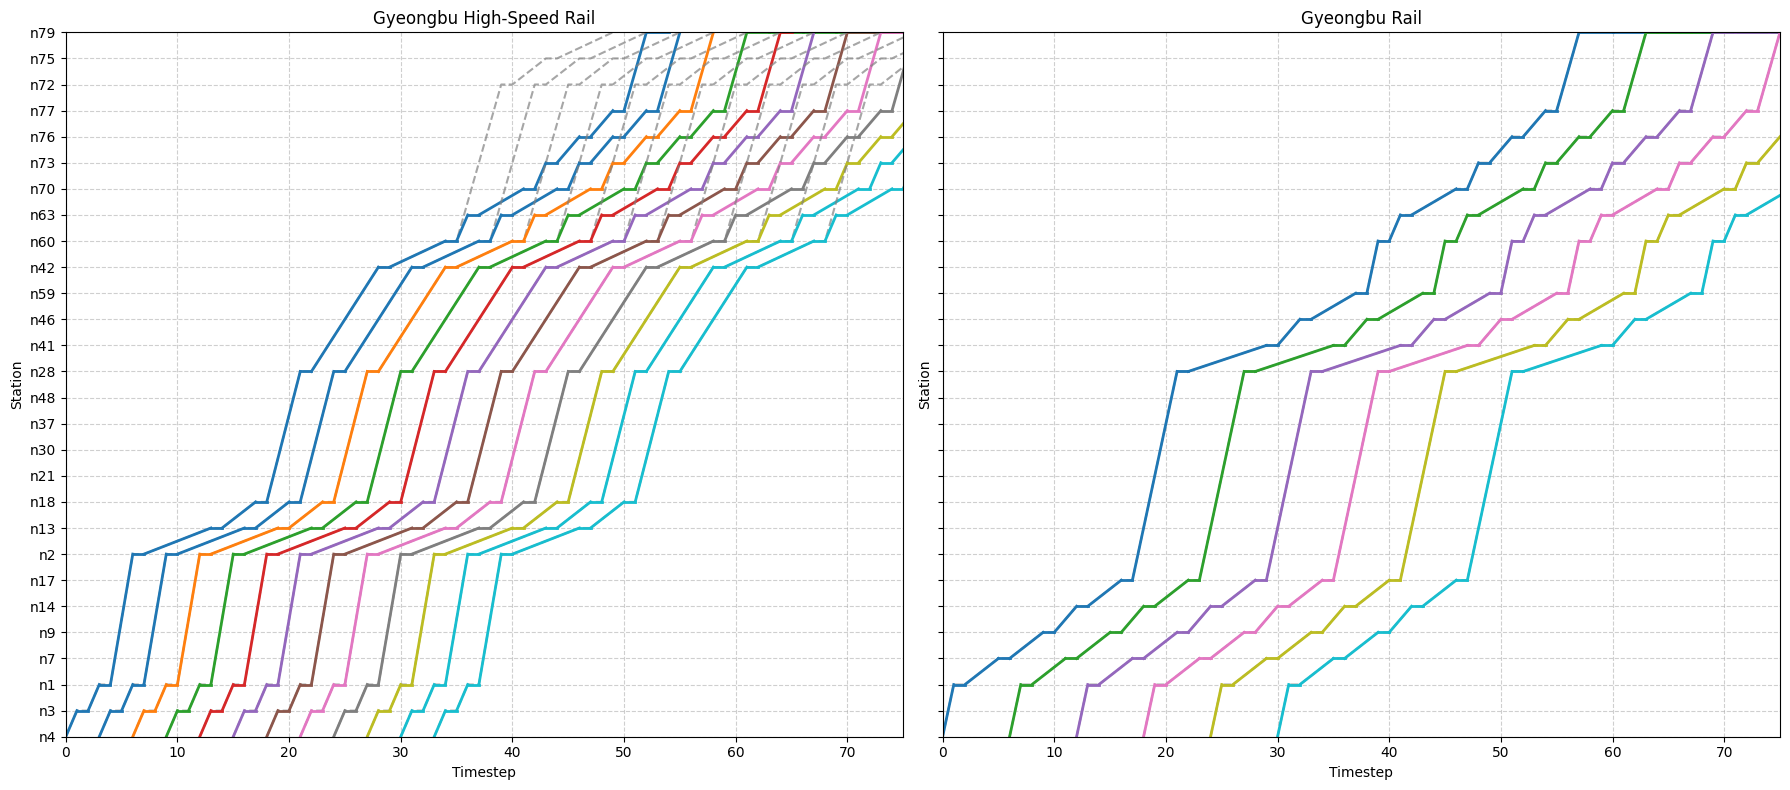

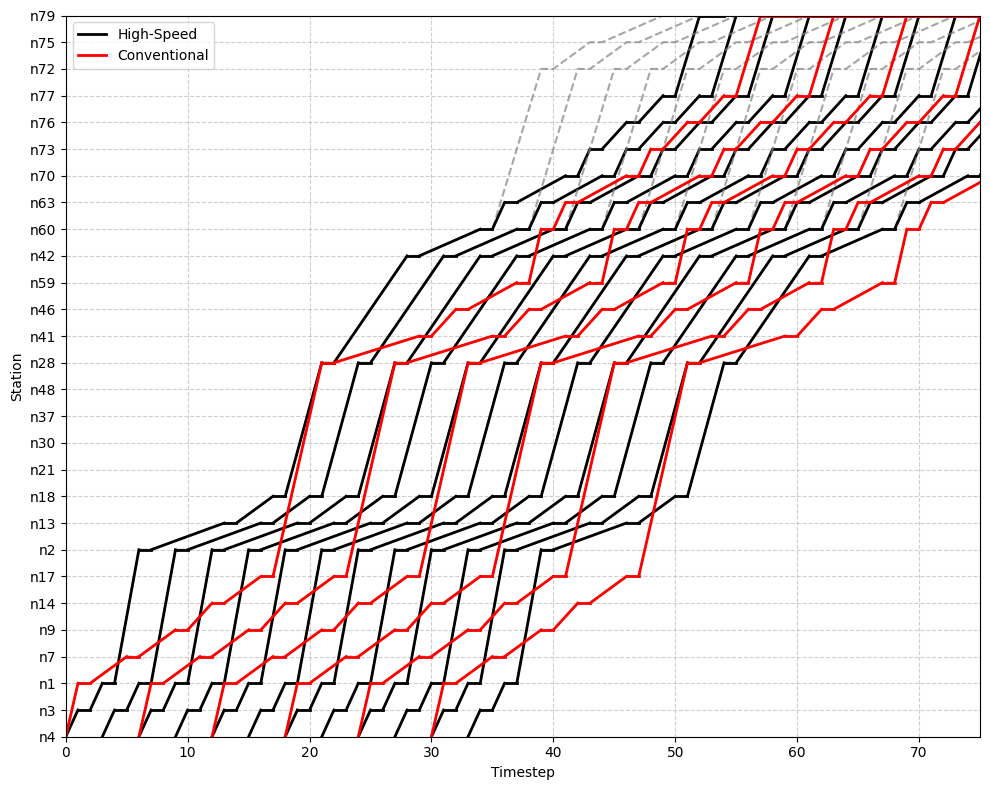

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

SINK = "SINK"

def sched_arr(tr, node, default=None):
    e = sched.get(tr, {}).get(node)
    if isinstance(e, dict) and ("arr" in e):
        return e["arr"]
    return default

def sched_dep(tr, node, default=None):
    e = sched.get(tr, {}).get(node)
    if isinstance(e, dict) and ("dep" in e):
        return e["dep"]
    return default


# 1) routes_nodes의 순서를 그대로 존중하면서 여러 경로를 하나로 병합
def merge_orders(base_order, new_order):
    res = list(base_order)
    for i, node in enumerate(new_order):
        if node in res:
            continue
        prev_node = new_order[i-1] if i > 0 else None
        next_node = new_order[i+1] if i+1 < len(new_order) else None
        if prev_node in res:
            res.insert(res.index(prev_node) + 1, node)
        elif next_node in res:
            res.insert(res.index(next_node), node)
        else:
            res.append(node)
    return res

def build_canonical_station_order(route_ids, routes_nodes):
    order = []
    for rid in route_ids:
        seq = routes_nodes[rid]
        order = merge_orders(order, seq)
    return order

# 2) 플롯 함수: 외부에서 만든 station_map을 사용하도록 변경
def plot_train_paths(train_list, ax, title, x_val, arc_list, h_get, 
                     routes_nodes, sched, station_map, xmax, color=None, label=None):
    if title is not None:
        ax.set_title(title)
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Station")

    # 공통 y축
    order = list(station_map.keys())
    yticks = [station_map[n] for n in order]
    ax.set_yticks(yticks)
    ax.set_yticklabels(order)

    # 색상 설정
    if color is None:  # 여러 열차 → colormap
        cmap = plt.cm.get_cmap('tab10', max(1, len(train_list)))
        color_iter = (cmap(i % cmap.N) for i in range(len(train_list)))
    else:             # 단일색
        color_iter = (color for _ in range(len(train_list)))

    for tr, tr_color in zip(train_list, color_iter):
        if h_get(tr) < 0.5:
            continue

        # --- 계획 경로(점선, 회색) : arr/dep 모두 사용 ---
        planned_path = routes_nodes[tr]
        p_nodes = [n for n in planned_path if n in station_map]

        plan_pts = []
        for n in p_nodes:
            t_arr = sched_arr(tr, n, None)
            t_dep = sched_dep(tr, n, None)
            y     = station_map[n]
            if t_arr is not None:
                plan_pts.append((t_arr, y))
            if (t_dep is not None) and (t_arr is not None) and (t_dep < t_arr):
                t_dep = t_arr
            if (t_dep is not None) and (t_dep != t_arr):
                plan_pts.append((t_dep, y))

        plan_pts = sorted(plan_pts, key=lambda xy: xy[0])

        if len(plan_pts) >= 2:
            p_times, p_ys = zip(*plan_pts)
            ax.plot(list(p_times), list(p_ys), linestyle='--', color='gray', alpha=0.7)


        # --- 실제 경로 ---
        actual_legs = []
        tr_i = trains.index(tr)
        for k in range(len(arc_list)):
            if x_val.get((k, tr_i), 0) > 0.5:
                fr, to, eid, *_ = arc_list[k]
                u, t0 = fr.split("^")
                v, t1 = to.split("^")
                if u == SINK or v == SINK:
                    continue
                actual_legs.append((int(t0), u, v, int(t1), eid))
        actual_legs.sort(key=lambda x: x[0])
        if not actual_legs:
            continue

        # 첫 구간
        t0, u, v, t1, _ = actual_legs[0]
        if u in station_map and v in station_map:
            ax.plot([t0, t1], [station_map[u], station_map[v]], 
                    color=tr_color, linewidth=2, label=label)
            label = None  # 첫 선만 legend에 표시

        # 이후 구간 + 대기
        for i in range(1, len(actual_legs)):
            p_t0, p_u, p_v, p_t1, _ = actual_legs[i-1]
            c_t0, c_u, c_v, c_t1, _ = actual_legs[i]

            # 대기(정차) 시각화
            if c_t0 > p_t1 and p_v == c_u and p_v in station_map:
                ax.plot([p_t1, c_t0], [station_map[p_v], station_map[c_u]],
                        color='r', linestyle=':', linewidth=1.8)

            # 이동 구간
            if c_u in station_map and c_v in station_map:
                ax.plot([c_t0, c_t1], [station_map[c_u], station_map[c_v]], 
                        color=tr_color, linewidth=2)

    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_xlim(0, xmax)
    ax.set_ylim(1, len(station_map))

# 3) 병합 기준 역 순서 만들기
gbrt_trains = [tr for tr in trains if str(tr).startswith('경부고속철도1')]
gbs_trains  = [tr for tr in trains if str(tr).startswith('경부선1')]
gbh_trains  = [tr for tr in trains if str(tr).startswith('호남고속철도1')]

def pick_representative(tr_list):
    return max(tr_list, key=lambda tr: len(routes_nodes[tr])) if tr_list else None

merge_route_ids = []
if '경부고속철도1_1' in routes_nodes:
    merge_route_ids.append('경부고속철도1_1')
elif gbrt_trains:
    merge_route_ids.append(pick_representative(gbrt_trains))

if '경부선1_1' in routes_nodes:
    merge_route_ids.append('경부선1_1')
elif gbs_trains:
    merge_route_ids.append(pick_representative(gbs_trains))

if '호남고속철도1_1' in routes_nodes:
    merge_route_ids.append('호남고속철도1_1')
elif gbh_trains:
    merge_route_ids.append(pick_representative(gbh_trains))

if not merge_route_ids:
    merge_route_ids = [pick_representative(trains)]

# h_get 정의 (T_aff/hvar 없을 때 방어)
try:
    _ = hvar
    def h_get(tr):
        try: return float(hvar[tr].X)
        except KeyError: return 1.0
except NameError:
    h_get = lambda tr: 1.0

canonical_order = build_canonical_station_order(merge_route_ids, routes_nodes)
if not canonical_order:
    from collections import Counter
    cnt = Counter(n for seq in routes_nodes.values() for n in seq if n != SINK)
    canonical_order = [n for n, _ in cnt.most_common()]

station_map = {name: i+1 for i, name in enumerate(canonical_order)}

# --- fig.1 ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), sharey=True)
plot_train_paths(gbrt_trains, ax1, "Gyeongbu High-Speed Rail", 
                 x_val, arc_list, h_get, routes_nodes, sched, station_map, xmax=75)
plot_train_paths(gbs_trains,  ax2, "Gyeongbu Rail",     
                 x_val, arc_list, h_get, routes_nodes, sched, station_map, xmax=75)
plt.tight_layout(); plt.show()

# --- fig.2 ---
fig2, ax = plt.subplots(figsize=(10, 8))
plot_train_paths(gbrt_trains, ax, None, 
                 x_val, arc_list, h_get, routes_nodes, sched, station_map, 
                 xmax=75, color="black", label="High-Speed")
plot_train_paths(gbs_trains, ax, None, 
                 x_val, arc_list, h_get, routes_nodes, sched, station_map, 
                 xmax=75, color="red", label="Conventional")
ax.legend()
plt.tight_layout(); plt.show()